Create Notebook with CamelCase Naming and Markdown Cells
Here is the complete notebook with CamelCase naming and all markdown cells:
Cell 1 (Markdown - Title):
Markdown
Code
Preview
# Task 2a: Traffic Sign Detection using Faster R-CNN

**Author:** Francesco  
**Architecture:** Faster R-CNN with ResNet-50 FPN Backbone  
**Dataset:** COCO Format (signs_coco/result.json)  
**GPU:** Optimized for GTX 1660 6GB VRAM  

## Notebook Structure
1. Configuration and Imports
2. Dataset Class with Path Fixes
3. Data Augmentation Transforms
4. Data Loading and Validation
5. Model Architecture Setup
6. Optimizer and Learning Rate Scheduler
7. Training Functions
8. Main Training Execution
9. Visualization and Analytics
10. Model Export

In [2]:
import os
import json
import time
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

warnings.filterwarnings('ignore')

#Enable for detailed CUDA debugging 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


class Config:
    DataRoot = "signs_coco"
    AnnotationsFile = "signs_coco/result.json"
    ImagesDir = "signs_coco/images"
    OutputDir = "outputs/faster_rcnn"
    LogDir = "logs/faster_rcnn"
    
    NumClasses = 39
    Backbone = "resnet50_fpn"
    
    BatchSize = 2  
    NumEpochs = 10
    LearningRate = 0.005
    Momentum = 0.9
    WeightDecay = 0.0005
    LrSchedulerStep = 3
    LrSchedulerGamma = 0.1
    
    Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SaveFrequency = 5
    RandomSeed = 42
    ValSplit = 0.2
    NumWorkers = 0 


os.makedirs(Config.OutputDir, exist_ok=True)
os.makedirs(Config.LogDir, exist_ok=True)

print(f"Device: {Config.Device}")
print(f"BatchSize: {Config.BatchSize}")
print(f"OutputDir: {Config.OutputDir}")

Device: cuda
BatchSize: 2
OutputDir: outputs/faster_rcnn


## Step 2: Dataset Class for COCO Format

Custom PyTorch Dataset that handles:
- Full path extraction from COCO JSON (fixes path issues)
- Empty annotation handling (images with no signs)
- Label validation to ensure indices are within valid range

In [3]:
class TrafficSignDataset(Dataset):
    
    def __init__(self, rootDir: str, annotationFile: str, transforms=None):
        self.RootDir = Path(rootDir)
        self.Transforms = transforms
        
        with open(annotationFile, 'r') as f:
            self.CocoData = json.load(f)
        
        self.Images = self.CocoData['images']
        self.Annotations = self.CocoData['annotations']
        self.Categories = self.CocoData['categories']
        
        self.ImageToAnnotations = {}
        for ann in self.Annotations:
            imgId = ann['image_id']
            if imgId not in self.ImageToAnnotations:
                self.ImageToAnnotations[imgId] = []
            self.ImageToAnnotations[imgId].append(ann)
        
        self.CatIdToIdx = {cat['id']: idx+1 for idx, cat in enumerate(self.Categories)}
        
        print(f"Loaded {len(self.Images)} images, {len(self.Annotations)} annotations")
        print(f"Categories: {len(self.Categories)}")
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        imgInfo = self.Images[idx]
        imgId = imgInfo['id']
        
        fileName = Path(imgInfo['file_name']).name
        imgPath = self.RootDir / 'images' / fileName
        
        image = Image.open(imgPath).convert("RGB")
        anns = self.ImageToAnnotations.get(imgId, [])
        
        if len(anns) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes, labels, areas, iscrowd = [], [], [], []
            
            for ann in anns:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                
                catIdx = self.CatIdToIdx[ann['category_id']]
                if catIdx >= Config.NumClasses:
                    raise ValueError(f"Invalid label {catIdx} >= NumClasses {Config.NumClasses}")
                labels.append(catIdx)
                areas.append(ann.get('area', w * h))
                iscrowd.append(ann.get('iscrowd', 0))
            
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([imgId]),
            "area": areas,
            "iscrowd": iscrowd
        }
        
        if self.Transforms:
            image, target = self.Transforms(image, target)
            
        return image, target
    
    def __len__(self) -> int:
        return len(self.Images)
    
    def GetClassNames(self) -> List[str]:
        names = ["background"]
        for cat in sorted(self.Categories, key=lambda x: x['id']):
            names.append(cat['name'])
        return names

## Step 3: Data Augmentation and Transforms

Custom Compose class that applies transforms to both image and target (bounding boxes).
Includes RandomHorizontalFlip for data augmentation during training.

In [4]:
class Compose:
    def __init__(self, transforms):
        self.Transforms = transforms

    def __call__(self, image, target):
        for t in self.Transforms:
            image, target = t(image, target)
        return image, target


class ToTensor:
    def __call__(self, image, target):
        image = T.ToTensor()(image)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.Prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.Prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
        return image, target


def GetTransform(train=True):
    transforms = [ToTensor()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

## Step 4: Data Loading and Validation Split

Load the COCO dataset, validate that labels are within expected range,
and split into training and validation sets using scikit-learn.

In [5]:
print("Loading dataset...")
FullDataset = TrafficSignDataset(
    rootDir=Config.DataRoot,
    annotationFile=Config.AnnotationsFile,
    transforms=GetTransform(train=True)
)


assert Config.NumClasses == len(FullDataset.Categories) + 1, \
    f"Config.NumClasses should be {len(FullDataset.Categories) + 1}"

maxLabel = max(FullDataset.CatIdToIdx.values())
print(f"MaxLabel: {maxLabel}, Config.NumClasses: {Config.NumClasses}")

if maxLabel >= Config.NumClasses:
    raise ValueError("Invalid labels detected in dataset!")


indices = list(range(len(FullDataset)))
trainIdx, valIdx = train_test_split(
    indices, 
    test_size=Config.ValSplit, 
    random_state=Config.RandomSeed
)

DatasetTrain = Subset(FullDataset, trainIdx)

DatasetValRaw = TrafficSignDataset(
    Config.DataRoot, 
    Config.AnnotationsFile, 
    GetTransform(train=False)
)
DatasetVal = Subset(DatasetValRaw, valIdx)

print(f"Train images: {len(trainIdx)}, Val images: {len(valIdx)}")

def CollateFn(batch):
    return tuple(zip(*batch))

DataLoaderTrain = DataLoader(
    DatasetTrain,
    batch_size=Config.BatchSize,
    shuffle=True,
    num_workers=Config.NumWorkers,
    collate_fn=CollateFn,
    pin_memory=False
)

DataLoaderVal = DataLoader(
    DatasetVal,
    batch_size=Config.BatchSize,
    shuffle=False,
    num_workers=Config.NumWorkers,
    collate_fn=CollateFn,
    pin_memory=False
)

print(f"Train batches: {len(DataLoaderTrain)}, Val batches: {len(DataLoaderVal)}")

Loading dataset...
Loaded 602 images, 899 annotations
Categories: 38
MaxLabel: 38, Config.NumClasses: 39
Loaded 602 images, 899 annotations
Categories: 38
Train images: 481, Val images: 121
Train batches: 241, Val batches: 61


## Step 5: Model Architecture Setup

Create Faster R-CNN with ResNet-50 FPN backbone.
Replace the classifier head to match our number of classes (39).
Move model to CUDA device and clear cache to optimize VRAM usage.

In [6]:
def CreateModel(numClasses: int):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    inFeatures = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses)
    return model


print(f"Creating model with {Config.NumClasses} classes...")

if Config.Device.type == 'cuda':
    torch.cuda.empty_cache()

Model = CreateModel(Config.NumClasses)
Model.to(Config.Device)

print(f"Model created on {Config.Device}")
print(f"Total parameters: {sum(p.numel() for p in Model.parameters()):,}")

if Config.Device.type == 'cuda':
    totalMem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU Memory: {totalMem:.1f} GB")

Creating model with 39 classes...
Model created on cuda
Total parameters: 41,488,786
GPU Memory: 5.6 GB


## Step 6: Optimizer and Learning Rate Scheduler

SGD optimizer with momentum and weight decay.
StepLR scheduler reduces learning rate every 3 epochs.
TensorBoard writer for training metrics logging.

In [ ]:
Params = [p for p in Model.parameters() if p.requires_grad]
Optimizer = torch.optim.SGD(
    Params,
    lr=Config.LearningRate,
    momentum=Config.Momentum,
    weight_decay=Config.WeightDecay
)


LrScheduler = torch.optim.lr_scheduler.StepLR(
    Optimizer,
    step_size=Config.LrSchedulerStep,
    gamma=Config.LrSchedulerGamma
)


Writer = SummaryWriter(log_dir=Config.LogDir)

print(f"Optimizer: SGD")
print(f"  LearningRate: {Config.LearningRate}")
print(f"  Momentum: {Config.Momentum}")
print(f"  WeightDecay: {Config.WeightDecay}")
print(f"Scheduler: StepLR (step={Config.LrSchedulerStep}, gamma={Config.LrSchedulerGamma})")
print(f"TensorBoard: tensorboard --logdir={Config.LogDir}")

Optimizer: SGD
  LearningRate: 0.005
  Momentum: 0.9
  WeightDecay: 0.0005
Scheduler: StepLR (step=3, gamma=0.1)
TensorBoard: tensorboard --logdir=logs/faster_rcnn


## Step 7: Training and Evaluation Functions

`TrainOneEpoch`: Runs one epoch of training, computes losses, performs backpropagation.
`Evaluate`: Runs inference on validation set, returns detection results for mAP calculation.

Handles:
- Empty target filtering (skips images with no annotations)
- GPU memory monitoring
- Loss tracking by component (classifier, box regression, RPN)

In [ ]:
def TrainOneEpoch(model, optimizer, dataLoader, device, epochIdx):
    model.train()
    totalLoss = 0
    lossesByType = {
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }
    
    for i, (images, targets) in enumerate(dataLoader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Skip batches with no valid targets
        validTargets = [t for t in targets if len(t['boxes']) > 0]
        if not validTargets:
            continue
        
        lossDict = model(images, targets)
        losses = sum(loss for loss in lossDict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        totalLoss += losses.item()
        for k, v in lossDict.items():
            lossesByType[k] += v.item()
        
        if i % 10 == 0:
            memInfo = ""
            if device.type == 'cuda':
                memAllocated = torch.cuda.memory_allocated(device) / 1024**3
                memInfo = f" GPU: {memAllocated:.1f}GB"
            print(f"  [Epoch {epochIdx}] Batch {i}/{len(dataLoader)}, Loss: {losses.item():.4f}{memInfo}")
    
    avgLoss = totalLoss / len(dataLoader)
    avgByType = {k: v / len(dataLoader) for k, v in lossesByType.items()}
    return avgLoss, avgByType


def Evaluate(model, dataLoader, device):
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, targets in dataLoader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                imageId = targets[i]['image_id'].item()
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                
                for box, score, label in zip(boxes, scores, labels):
                    results.append({
                        'image_id': imageId,
                        'category_id': label,
                        'bbox': [float(box[0]), float(box[1]), 
                                float(box[2]-box[0]), float(box[3]-box[1])],
                        'score': float(score)
                    })
    
    return results

## Step 8: Main Training Execution

Execute the training loop for configured number of epochs:
- Train on training set
- Log metrics to TensorBoard
- Run validation
- Save checkpoints periodically
- Clear GPU cache between epochs to prevent OOM

Checkpoints saved to `outputs/faster_rcnn/`

In [ ]:
print("Starting Training...")
print("=" * 60)

bestLoss = float('inf')

for epoch in range(Config.NumEpochs):
    startTime = time.time()
    
    avgLoss, lossBreakdown = TrainOneEpoch(
        Model, Optimizer, DataLoaderTrain, Config.Device, epoch
    )
    
    LrScheduler.step()
    
    Writer.add_scalar('Loss/train_total', avgLoss, epoch)
    for k, v in lossBreakdown.items():
        Writer.add_scalar(f'Loss/{k}', v, epoch)
    Writer.add_scalar('Learning_rate', Optimizer.param_groups[0]['lr'], epoch)
    
    print(f"\n[Epoch {epoch}] Running validation...")
    valResults = Evaluate(Model, DataLoaderVal, Config.Device)
    print(f"Validation detections: {len(valResults)}")
    
    if avgLoss < bestLoss or epoch % Config.SaveFrequency == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': Model.state_dict(),
            'optimizer_state_dict': Optimizer.state_dict(),
            'loss': avgLoss,
            'config': {
                'NumClasses': Config.NumClasses,
                'BatchSize': Config.BatchSize,
                'LearningRate': Config.LearningRate,
                'NumEpochs': Config.NumEpochs,
                'Backbone': Config.Backbone,
                'Device': str(Config.Device)
            }
        }
        savePath = os.path.join(Config.OutputDir, f'faster_rcnn_epoch_{epoch}.pth')
        torch.save(checkpoint, savePath)
        print(f"✓ Checkpoint saved: {savePath}")
        bestLoss = min(bestLoss, avgLoss)
    
    if Config.Device.type == 'cuda':
        torch.cuda.empty_cache()
    
    elapsed = time.time() - startTime
    print(f"Epoch {epoch} completed in {elapsed:.1f}s, Avg Loss: {avgLoss:.4f}")
    print("=" * 60)

print("Training Completed!")

Starting Training...
  [Epoch 0] Batch 0/241, Loss: 4.1675 GPU: 0.7GB
  [Epoch 0] Batch 10/241, Loss: 0.3575 GPU: 1.2GB
  [Epoch 0] Batch 20/241, Loss: 0.3479 GPU: 0.8GB
  [Epoch 0] Batch 30/241, Loss: 0.4396 GPU: 0.8GB
  [Epoch 0] Batch 40/241, Loss: 0.2740 GPU: 0.7GB
  [Epoch 0] Batch 50/241, Loss: 0.2892 GPU: 0.8GB
  [Epoch 0] Batch 60/241, Loss: 0.3324 GPU: 0.7GB
  [Epoch 0] Batch 70/241, Loss: 0.4685 GPU: 0.8GB
  [Epoch 0] Batch 80/241, Loss: 0.2854 GPU: 0.8GB
  [Epoch 0] Batch 90/241, Loss: 0.3272 GPU: 0.7GB
  [Epoch 0] Batch 100/241, Loss: 0.3707 GPU: 0.7GB
  [Epoch 0] Batch 110/241, Loss: 0.4304 GPU: 0.7GB
  [Epoch 0] Batch 120/241, Loss: 0.7763 GPU: 0.8GB
  [Epoch 0] Batch 130/241, Loss: 0.5375 GPU: 0.7GB
  [Epoch 0] Batch 140/241, Loss: 0.2179 GPU: 0.7GB
  [Epoch 0] Batch 150/241, Loss: 0.5107 GPU: 0.8GB
  [Epoch 0] Batch 160/241, Loss: 0.5602 GPU: 0.7GB
  [Epoch 0] Batch 170/241, Loss: 0.3417 GPU: 0.7GB
  [Epoch 0] Batch 180/241, Loss: 0.2024 GPU: 0.7GB
  [Epoch 0] Batch 190

## Step 9: Visualization and Analytics

Visualize model predictions vs ground truth on validation set.
Left column shows ground truth annotations (green).
Right column shows model predictions with confidence scores (red).

Generating visualizations...
Saved visualization to: outputs/faster_rcnn/predictions_comparison.png


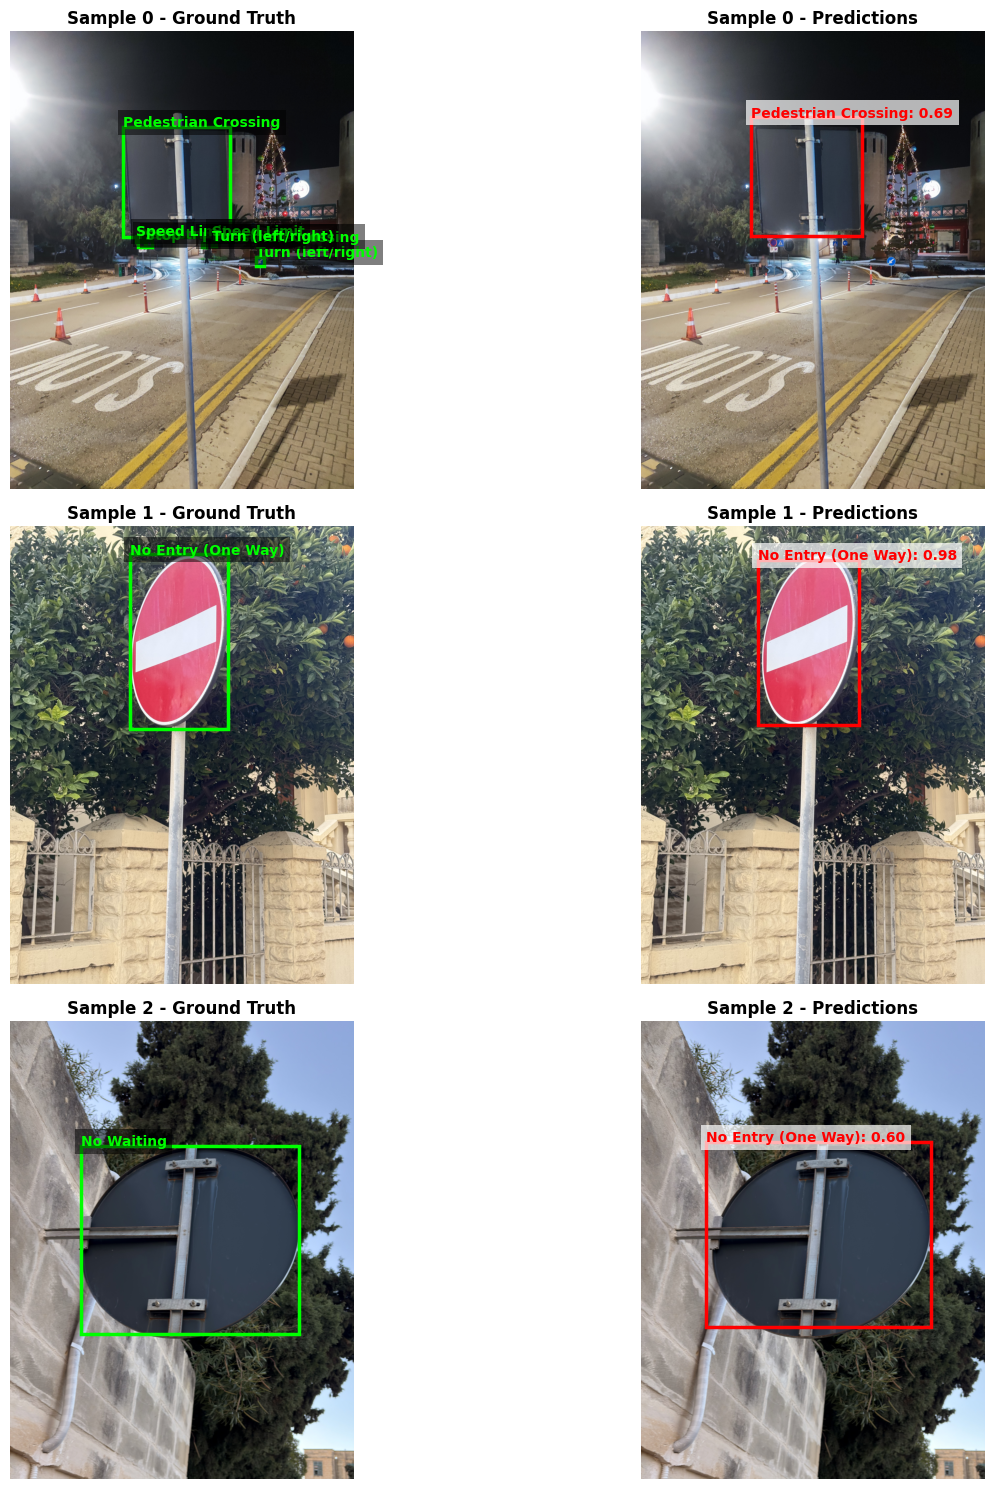

In [ ]:
def VisualizePredictions(model, dataset, device, numSamples=3, scoreThreshold=0.5):
    model.eval()
    
    if hasattr(dataset, 'dataset'):
        classNames = dataset.dataset.GetClassNames()
        totalSamples = len(dataset)
    else:
        classNames = dataset.GetClassNames()
        totalSamples = len(dataset)
    
    actualSamples = min(numSamples, totalSamples)
    if actualSamples == 0:
        print("No samples to visualize")
        return
    
    fig, axes = plt.subplots(actualSamples, 2, figsize=(15, 5*actualSamples))
    if actualSamples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for plotIdx in range(actualSamples):
            image, target = dataset[plotIdx]
            
            pred = model([image.to(device)])[0]
            
            imgNp = image.permute(1, 2, 0).cpu().numpy()
            
            ax = axes[plotIdx, 0]
            ax.imshow(imgNp)
            ax.set_title(f"Sample {plotIdx} - Ground Truth", fontsize=12, weight='bold')
            
            if len(target['boxes']) > 0:
                for box, label in zip(target['boxes'], target['labels']):
                    x1, y1, x2, y2 = box.cpu().numpy()
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       fill=False, edgecolor='lime', linewidth=2.5)
                    ax.add_patch(rect)
                    ax.text(x1, max(y1-5, 15), classNames[label], 
                           color='lime', fontsize=10, weight='bold',
                           bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            else:
                ax.text(0.5, 0.5, 'No Objects', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=14, color='gray')
            ax.axis('off')
            
            ax = axes[plotIdx, 1]
            ax.imshow(imgNp)
            ax.set_title(f"Sample {plotIdx} - Predictions", fontsize=12, weight='bold')
            
            predCount = 0
            for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
                if score > scoreThreshold:
                    x1, y1, x2, y2 = box.cpu().numpy()
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                       fill=False, edgecolor='red', linewidth=2.5)
                    ax.add_patch(rect)
                    ax.text(x1, max(y1-5, 15), f"{classNames[label]}: {score:.2f}", 
                           color='red', fontsize=10, weight='bold',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
                    predCount += 1
            
            if predCount == 0:
                ax.text(0.5, 0.5, 'No Predictions', ha='center', va='center',
                       transform=ax.transAxes, fontsize=14, color='gray')
            ax.axis('off')
    
    plt.tight_layout()
    
    savePath = os.path.join(Config.OutputDir, 'predictions_comparison.png')
    plt.savefig(savePath, dpi=150, bbox_inches='tight')
    print(f"Saved visualization to: {savePath}")
    
    plt.show()


print("Generating visualizations...")
VisualizePredictions(Model, DatasetVal, Config.Device, numSamples=3, scoreThreshold=0.5)

## Step 10: Model Export

Save final model state and training analytics.
Export checkpoint with configuration metadata for reproducibility.

In [ ]:
finalPath = os.path.join(Config.OutputDir, 'faster_rcnn_final.pth')
torch.save(Model.state_dict(), finalPath)
print(f"Final model saved: {finalPath}")

analytics = {
    'Model': 'Faster-RCNN ResNet50 FPN',
    'NumClasses': Config.NumClasses,
    'FinalLoss': avgLoss,
    'EpochsTrained': Config.NumEpochs,
    'Device': str(Config.Device),
    'TotalParameters': sum(p.numel() for p in Model.parameters()),
    'TrainImages': len(trainIdx),
    'ValImages': len(valIdx)
}

with open(os.path.join(Config.OutputDir, 'analytics.json'), 'w') as f:
    json.dump(analytics, f, indent=4)

print("\nAnalytics:")
for k, v in analytics.items():
    print(f"  {k}: {v}")

Writer.close()
print("\n Notebook completed successfully!")

## Evaluation & Statistics (per-epoch)

Loads each saved `faster_rcnn_epoch_*.pth`, validates on the **val** split, and prints:
mAP50, mAP50–95, Precision@0.5, Recall@0.5.


In [2]:
import json
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

dataRoot = Path("signs_coco")
annotationsFile = dataRoot / "result.json"
imagesDir = dataRoot / "images"
outputDir = Path("outputs/faster_rcnn")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 2
numWorkers = 0
valSplit = 0.2
randomSeed = 42

if not annotationsFile.exists():
    raise FileNotFoundError(f"Missing: {annotationsFile}")
if not imagesDir.exists():
    raise FileNotFoundError(f"Missing: {imagesDir}")
if not outputDir.exists():
    raise FileNotFoundError(f"Missing: {outputDir}")

epochPaths = sorted(outputDir.glob("faster_rcnn_epoch_*.pth"), key=lambda p: p.stat().st_mtime)
if len(epochPaths) == 0:
    raise FileNotFoundError(f"No checkpoints found in {outputDir}")

with open(annotationsFile, "r") as f:
    cocoData = json.load(f)

categories = cocoData["categories"]
numClasses = len(categories) + 1
catIdToIdx = {int(c["id"]): i + 1 for i, c in enumerate(categories)}
idxToCatId = {v: k for k, v in catIdToIdx.items()}

class CocoDetectionLike(Dataset):
    def __init__(self, annPath, imgDir, transforms):
        with open(annPath, "r") as f:
            d = json.load(f)
        self.images = d["images"]
        self.anns = d["annotations"]
        self.imgDir = Path(imgDir)
        self.transforms = transforms
        self.imageToAnns = {}
        for a in self.anns:
            self.imageToAnns.setdefault(int(a["image_id"]), []).append(a)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        imgInfo = self.images[idx]
        imgId = int(imgInfo["id"])
        fileName = Path(imgInfo["file_name"]).name
        imgPath = self.imgDir / fileName
        image = Image.open(imgPath).convert("RGB")

        anns = self.imageToAnns.get(imgId, [])
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        for a in anns:
            x, y, w, h = a["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(catIdToIdx[int(a["category_id"])])
            areas.append(float(a.get("area", w * h)))
            iscrowd.append(int(a.get("iscrowd", 0)))

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            areas = torch.tensor(areas, dtype=torch.float32)
            iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(imgId, dtype=torch.int64),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

def collateFn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

tfm = T.Compose([T.ToTensor()])
fullDataset = CocoDetectionLike(annotationsFile, imagesDir, tfm)

n = len(fullDataset)
rng = np.random.default_rng(randomSeed)
perm = rng.permutation(n)
valCount = max(1, int(round(n * valSplit)))
valIdx = perm[:valCount].tolist()
valDataset = Subset(fullDataset, valIdx)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers, collate_fn=collateFn)

valImgIds = []
for i in valIdx:
    _, t = fullDataset[i]
    valImgIds.append(int(t["image_id"]))

def createModel(nc):
    m = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    inFeat = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor = FastRCNNPredictor(inFeat, nc)
    return m

def loadState(m, p):
    payload = torch.load(p, map_location=device)
    if isinstance(payload, dict) and "model_state_dict" in payload:
        m.load_state_dict(payload["model_state_dict"])
    else:
        m.load_state_dict(payload)

def evaluateDetections(m):
    m.eval()
    results = []
    with torch.no_grad():
        for images, targets in valLoader:
            images = [img.to(device) for img in images]
            outputs = m(images)
            for out, tgt in zip(outputs, targets):
                imgId = int(tgt["image_id"])
                boxes = out["boxes"].detach().cpu().numpy()
                scores = out["scores"].detach().cpu().numpy()
                labels = out["labels"].detach().cpu().numpy()
                for b, s, lab in zip(boxes, scores, labels):
                    cocoCat = idxToCatId.get(int(lab), None)
                    if cocoCat is None:
                        continue
                    x1, y1, x2, y2 = b.tolist()
                    results.append(
                        {
                            "image_id": imgId,
                            "category_id": int(cocoCat),
                            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                            "score": float(s)
                        }
                    )
    return results

cocoGt = COCO(str(annotationsFile))

rows = []
print(f"Device: {device}")
print(f"Val images: {len(valIdx)} | Checkpoints: {len(epochPaths)}")
print("\n--- Per-epoch Key Statistics ---")

for p in epochPaths:
    model = createModel(numClasses).to(device)
    loadState(model, p)
    dets = evaluateDetections(model)

    if len(dets) == 0:
        print(f"{p.name}: mAP50=N/A mAP50-95=N/A Precision=N/A Recall=N/A (no detections)")
        rows.append(
            {
                "checkpoint": p.name,
                "mAP50": np.nan,
                "mAP50_95": np.nan,
                "precision@0.5": np.nan,
                "recall@0.5": np.nan,
                "detections": 0
            }
        )
        continue

    cocoDt = cocoGt.loadRes(dets)
    cocoEval = COCOeval(cocoGt, cocoDt, "bbox")
    cocoEval.params.imgIds = valImgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    map50_95 = float(cocoEval.stats[0])
    map50 = float(cocoEval.stats[1])

    precisionTensor = cocoEval.eval["precision"]
    recallTensor = cocoEval.eval["recall"]
    iouThrs = np.array(cocoEval.params.iouThrs)
    maxDets = np.array(cocoEval.params.maxDets)

    t50Idx = np.where(np.isclose(iouThrs, 0.5))[0]
    t50 = int(t50Idx[0]) if len(t50Idx) else 0
    areaAll = 0
    m100Idx = np.where(maxDets == 100)[0]
    m100 = int(m100Idx[0]) if len(m100Idx) else -1

    precAt50 = precisionTensor[t50, :, :, areaAll, m100]
    validPrec = precAt50[precAt50 > -1]
    meanPrecision = float(np.mean(validPrec)) if validPrec.size else float("nan")

    recAt50 = recallTensor[t50, :, areaAll, m100]
    validRec = recAt50[recAt50 > -1]
    meanRecall = float(np.mean(validRec)) if validRec.size else float("nan")

    print(f"{p.name}: mAP50={map50:.4f} mAP50-95={map50_95:.4f} Precision={meanPrecision:.4f} Recall={meanRecall:.4f}")

    rows.append(
        {
            "checkpoint": p.name,
            "mAP50": map50,
            "mAP50_95": map50_95,
            "precision@0.5": meanPrecision,
            "recall@0.5": meanRecall,
            "detections": len(dets)
        }
    )

df = pd.DataFrame(rows).sort_values("mAP50_95", ascending=False).reset_index(drop=True)
print("\n--- Ranked (best first) ---")
display(df)

outCsv = outputDir / "val_epoch_metrics.csv"
df.to_csv(outCsv, index=False)
print(f"\nSaved: {outCsv}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Device: cuda
Val images: 120 | Checkpoints: 9

--- Per-epoch Key Statistics ---


/tmp/nix-shell.mDJ3Al/ipykernel_5096/3886354623.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(p, map_location=device)


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

,checkpoint,mAP50,mAP50_95,precision@0.5,recall@0.5,detections
0,faster_rcnn_epoch_9.pth,0.361868,0.294071,0.361868,0.478536,982
1,faster_rcnn_epoch_7.pth,0.359367,0.292969,0.359367,0.480729,1008
2,faster_rcnn_epoch_5.pth,0.357414,0.292876,0.357414,0.475173,995
3,faster_rcnn_epoch_6.pth,0.357814,0.288968,0.357814,0.480729,1000
4,faster_rcnn_epoch_4.pth,0.336388,0.271165,0.336388,0.457355,1081
5,faster_rcnn_epoch_3.pth,0.322702,0.256642,0.322702,0.455162,1044
6,faster_rcnn_epoch_2.pth,0.278858,0.199766,0.278858,0.442426,1490
7,faster_rcnn_epoch_1.pth,0.261368,0.186655,0.261368,0.442488,1638
8,faster_rcnn_epoch_0.pth,0.118285,0.078111,0.118285,0.283747,1051



Saved: outputs/faster_rcnn/val_epoch_metrics.csv


Best checkpoint: faster_rcnn_epoch_9.pth
Saving to: outputs/faster_rcnn/eval_best/best_20260130_231341


/tmp/nix-shell.mDJ3Al/ipykernel_5096/3291501239.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(pathObj, map_location=device)


Running COCO eval for PR curve data...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @

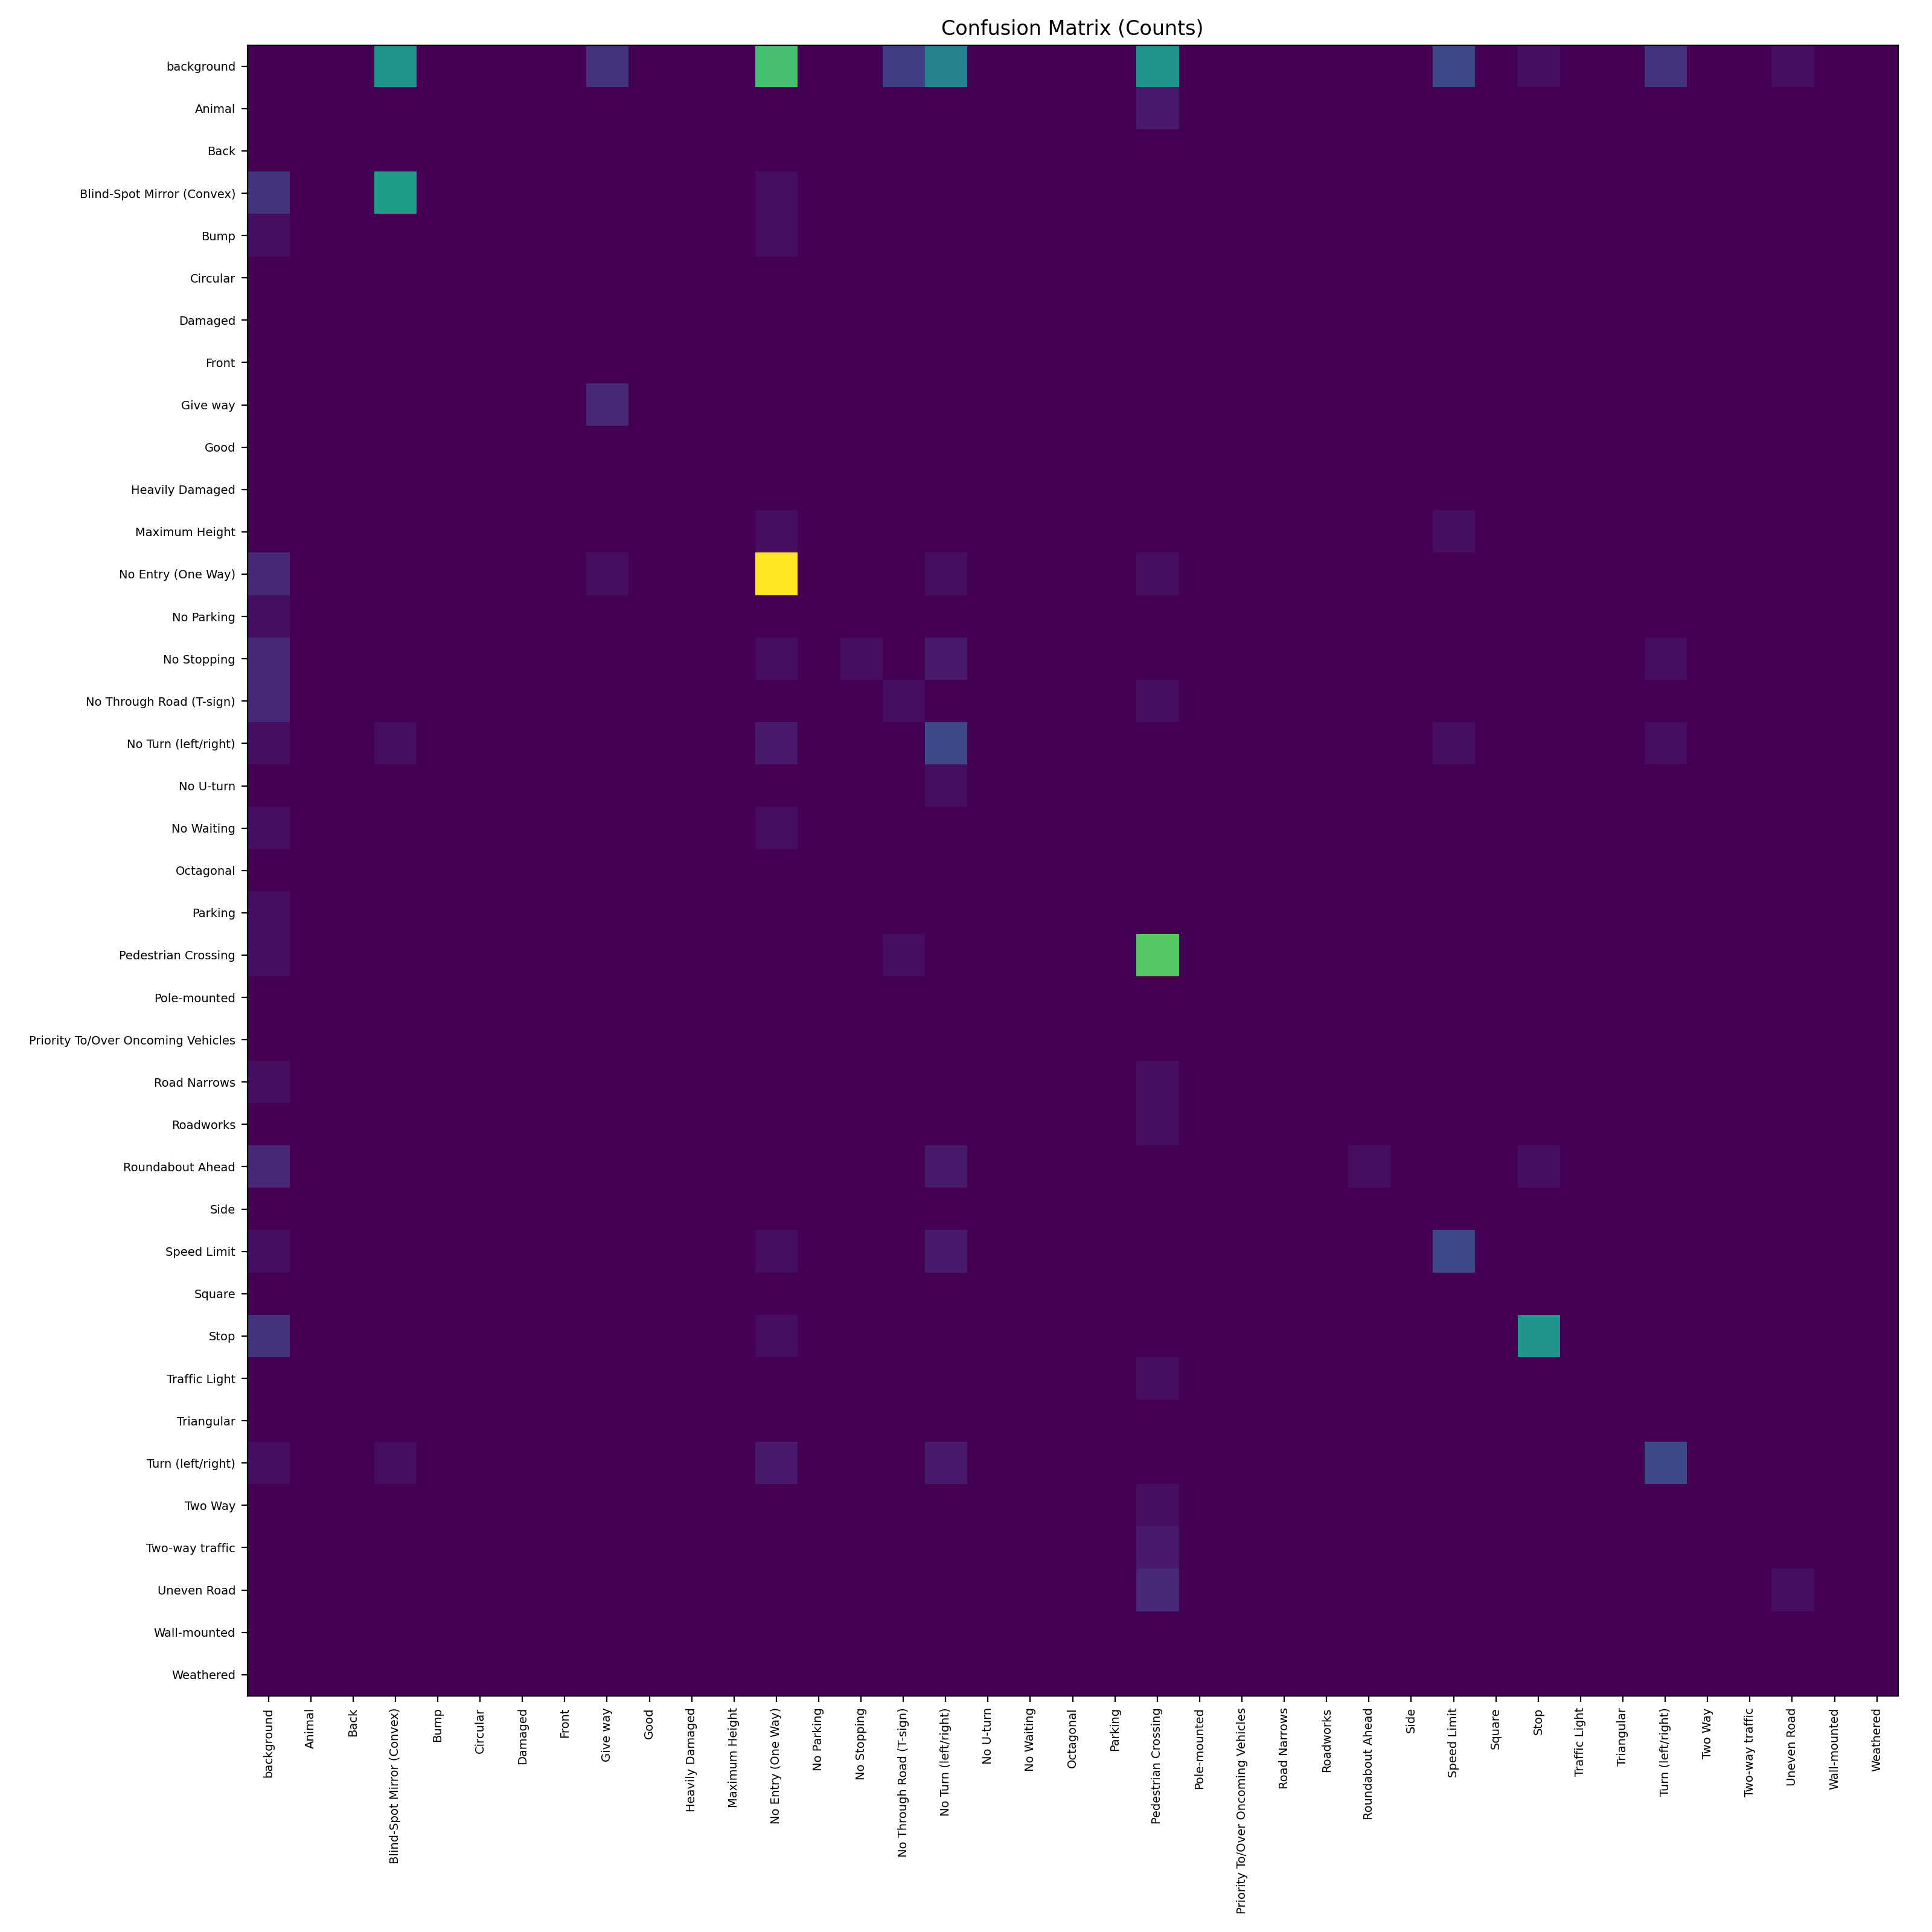


--- Precision-Recall Curve ---


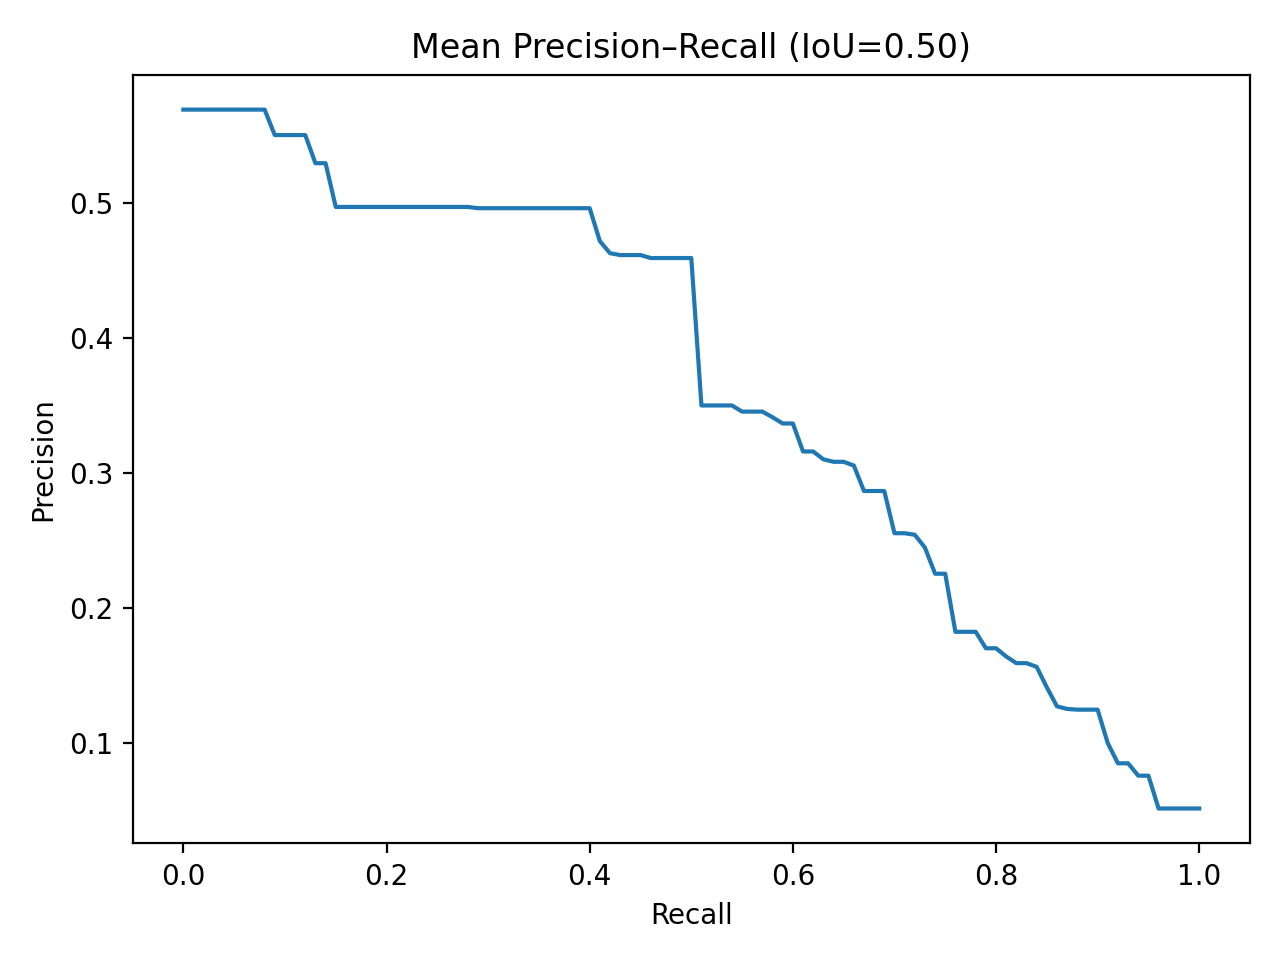

In [3]:
import json
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from IPython.display import Image as IpImage, display

dataRoot = Path("signs_coco")
annotationsFile = dataRoot / "result.json"
imagesDir = dataRoot / "images"
outputDir = Path("outputs/faster_rcnn")
metricsCsvCandidates = [outputDir / "val_epoch_metrics.csv", Path("/mnt/data/val_epoch_metrics.csv")]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 2
numWorkers = 0
valSplit = 0.2
randomSeed = 42
scoreThreshold = 0.25
iouThreshold = 0.5

if not annotationsFile.exists():
    raise FileNotFoundError(f"Missing: {annotationsFile}")
if not imagesDir.exists():
    raise FileNotFoundError(f"Missing: {imagesDir}")
if not outputDir.exists():
    raise FileNotFoundError(f"Missing: {outputDir}")

metricsCsv = None
for p in metricsCsvCandidates:
    if p.exists():
        metricsCsv = p
        break
if metricsCsv is None:
    raise FileNotFoundError(f"Could not find val_epoch_metrics.csv in {metricsCsvCandidates}")

df = pd.read_csv(metricsCsv)
df = df.dropna(subset=["mAP50_95"]).sort_values("mAP50_95", ascending=False).reset_index(drop=True)
if len(df) == 0:
    raise RuntimeError("No valid rows in val_epoch_metrics.csv (mAP50_95 missing).")

bestCheckpointName = str(df.loc[0, "checkpoint"])
bestCheckpointPath = outputDir / bestCheckpointName
if not bestCheckpointPath.exists():
    alt = Path(bestCheckpointName)
    if alt.exists():
        bestCheckpointPath = alt
    else:
        raise FileNotFoundError(f"Best checkpoint not found: {bestCheckpointPath}")

with open(annotationsFile, "r") as f:
    cocoData = json.load(f)

categories = cocoData["categories"]
numClasses = len(categories) + 1
catIdToIdx = {int(c["id"]): i + 1 for i, c in enumerate(categories)}
idxToCatId = {v: k for k, v in catIdToIdx.items()}

class CocoDetectionLike(Dataset):
    def __init__(self, annPath, imgDir, transforms):
        with open(annPath, "r") as f:
            d = json.load(f)
        self.images = d["images"]
        self.anns = d["annotations"]
        self.imgDir = Path(imgDir)
        self.transforms = transforms
        self.imageToAnns = {}
        for a in self.anns:
            self.imageToAnns.setdefault(int(a["image_id"]), []).append(a)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        imgInfo = self.images[idx]
        imgId = int(imgInfo["id"])
        fileName = Path(imgInfo["file_name"]).name
        imgPath = self.imgDir / fileName
        image = Image.open(imgPath).convert("RGB")

        anns = self.imageToAnns.get(imgId, [])
        boxes = []
        labels = []
        for a in anns:
            x, y, w, h = a["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(catIdToIdx[int(a["category_id"])])

        boxes = torch.tensor(boxes, dtype=torch.float32) if len(boxes) else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if len(labels) else torch.zeros((0,), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor(imgId, dtype=torch.int64)}

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

def collateFn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

tfm = T.Compose([T.ToTensor()])
fullDataset = CocoDetectionLike(annotationsFile, imagesDir, tfm)

n = len(fullDataset)
rng = np.random.default_rng(randomSeed)
perm = rng.permutation(n)
valCount = max(1, int(round(n * valSplit)))
valIdx = perm[:valCount].tolist()

valDataset = Subset(fullDataset, valIdx)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers, collate_fn=collateFn)

valImgIds = []
for i in valIdx:
    _, t = fullDataset[i]
    valImgIds.append(int(t["image_id"]))

def createModel(nc):
    m = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    inFeat = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor = FastRCNNPredictor(inFeat, nc)
    return m

def loadState(modelObj, pathObj):
    payload = torch.load(pathObj, map_location=device)
    if isinstance(payload, dict) and "model_state_dict" in payload:
        modelObj.load_state_dict(payload["model_state_dict"])
    else:
        modelObj.load_state_dict(payload)

def evaluateDetections(modelObj):
    modelObj.eval()
    results = []
    with torch.no_grad():
        for images, targets in valLoader:
            images = [img.to(device) for img in images]
            outputs = modelObj(images)
            for out, tgt in zip(outputs, targets):
                imgId = int(tgt["image_id"])
                boxes = out["boxes"].detach().cpu().numpy()
                scores = out["scores"].detach().cpu().numpy()
                labels = out["labels"].detach().cpu().numpy()
                for b, s, lab in zip(boxes, scores, labels):
                    cocoCat = idxToCatId.get(int(lab), None)
                    if cocoCat is None:
                        continue
                    x1, y1, x2, y2 = b.tolist()
                    results.append({"image_id": imgId, "category_id": int(cocoCat), "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)], "score": float(s)})
    return results

def iouMatrix(a, b):
    if a.size == 0 or b.size == 0:
        return np.zeros((a.shape[0], b.shape[0]), dtype=np.float32)
    a = a[:, None, :]
    b = b[None, :, :]
    x1 = np.maximum(a[..., 0], b[..., 0])
    y1 = np.maximum(a[..., 1], b[..., 1])
    x2 = np.minimum(a[..., 2], b[..., 2])
    y2 = np.minimum(a[..., 3], b[..., 3])
    interW = np.maximum(0.0, x2 - x1)
    interH = np.maximum(0.0, y2 - y1)
    inter = interW * interH
    areaA = np.maximum(0.0, a[..., 2] - a[..., 0]) * np.maximum(0.0, a[..., 3] - a[..., 1])
    areaB = np.maximum(0.0, b[..., 2] - b[..., 0]) * np.maximum(0.0, b[..., 3] - b[..., 1])
    union = areaA + areaB - inter + 1e-9
    return (inter / union).astype(np.float32)

def buildConfusionMatrix(modelObj, scoreThr, iouThr):
    cm = np.zeros((numClasses, numClasses), dtype=np.int64)
    modelObj.eval()
    with torch.no_grad():
        for images, targets in valLoader:
            images = [img.to(device) for img in images]
            outputs = modelObj(images)
            for out, tgt in zip(outputs, targets):
                gtBoxes = tgt["boxes"].detach().cpu().numpy().astype(np.float32)
                gtLabels = tgt["labels"].detach().cpu().numpy().astype(np.int64)

                predScores = out["scores"].detach().cpu().numpy().astype(np.float32)
                keep = predScores >= scoreThr
                predBoxes = out["boxes"].detach().cpu().numpy().astype(np.float32)[keep]
                predLabels = out["labels"].detach().cpu().numpy().astype(np.int64)[keep]

                iou = iouMatrix(gtBoxes, predBoxes)
                matchedGt = set()
                matchedPred = set()

                while iou.size:
                    gi, pi = np.unravel_index(np.argmax(iou), iou.shape)
                    best = float(iou[gi, pi])
                    if best < iouThr:
                        break
                    if gi in matchedGt or pi in matchedPred:
                        iou[gi, pi] = -1.0
                        continue
                    matchedGt.add(gi)
                    matchedPred.add(pi)
                    gtC = int(gtLabels[gi]) if gi < len(gtLabels) else 0
                    prC = int(predLabels[pi]) if pi < len(predLabels) else 0
                    if gtC < 0 or gtC >= numClasses:
                        gtC = 0
                    if prC < 0 or prC >= numClasses:
                        prC = 0
                    cm[gtC, prC] += 1
                    iou[gi, :] = -1.0
                    iou[:, pi] = -1.0

                for gi in range(len(gtLabels)):
                    if gi in matchedGt:
                        continue
                    gtC = int(gtLabels[gi])
                    if gtC < 0 or gtC >= numClasses:
                        gtC = 0
                    cm[gtC, 0] += 1

                for pi in range(len(predLabels)):
                    if pi in matchedPred:
                        continue
                    prC = int(predLabels[pi])
                    if prC < 0 or prC >= numClasses:
                        prC = 0
                    cm[0, prC] += 1
    return cm

def saveConfusion(cm, saveDir, classNames):
    rawPath = Path(saveDir) / "confusion_matrix.png"
    normPath = Path(saveDir) / "confusion_matrix_normalized.png"

    plt.figure(figsize=(16, 16))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks(np.arange(len(classNames)), classNames, rotation=90, fontsize=7)
    plt.yticks(np.arange(len(classNames)), classNames, fontsize=7)
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.savefig(rawPath, dpi=200)
    plt.close()

    rowSums = cm.sum(axis=1, keepdims=True).astype(np.float32)
    rowSums[rowSums == 0] = 1.0
    cmNorm = cm.astype(np.float32) / rowSums

    plt.figure(figsize=(16, 16))
    plt.imshow(cmNorm, interpolation="nearest")
    plt.xticks(np.arange(len(classNames)), classNames, rotation=90, fontsize=7)
    plt.yticks(np.arange(len(classNames)), classNames, fontsize=7)
    plt.title("Confusion Matrix (Row-Normalized)")
    plt.tight_layout()
    plt.savefig(normPath, dpi=200)
    plt.close()

    return rawPath, normPath

classNames = ["background"] + [c["name"] for c in categories]

evalDir = outputDir / "eval_best"
evalDir.mkdir(parents=True, exist_ok=True)
saveDir = evalDir / time.strftime("best_%Y%m%d_%H%M%S")
saveDir.mkdir(parents=True, exist_ok=True)

print(f"Best checkpoint: {bestCheckpointPath.name}")
print(f"Saving to: {saveDir}")

model = createModel(numClasses).to(device)
loadState(model, bestCheckpointPath)

print("Running COCO eval for PR curve data...")
dets = evaluateDetections(model)
cocoGt = COCO(str(annotationsFile))
cocoDt = cocoGt.loadRes(dets if len(dets) else [])
cocoEval = COCOeval(cocoGt, cocoDt, "bbox")
cocoEval.params.imgIds = valImgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

precisionTensor = cocoEval.eval["precision"]
iouThrs = np.array(cocoEval.params.iouThrs)
recThrs = np.array(cocoEval.params.recThrs)
maxDets = np.array(cocoEval.params.maxDets)

t50Idx = np.where(np.isclose(iouThrs, 0.5))[0]
t50 = int(t50Idx[0]) if len(t50Idx) else 0
areaAll = 0
m100Idx = np.where(maxDets == 100)[0]
m100 = int(m100Idx[0]) if len(m100Idx) else -1

precCurve = precisionTensor[t50, :, :, areaAll, m100]
meanPrecByRecall = []
for r in range(precCurve.shape[0]):
    v = precCurve[r, :]
    v = v[v > -1]
    meanPrecByRecall.append(float(np.mean(v)) if v.size else np.nan)
meanPrecByRecall = np.array(meanPrecByRecall, dtype=np.float32)

prPath = Path(saveDir) / "PR_curve.png"
plt.figure()
plt.plot(recThrs, meanPrecByRecall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Mean Precision–Recall (IoU=0.50)")
plt.tight_layout()
plt.savefig(prPath, dpi=200)
plt.close()

print("Building confusion matrix...")
cm = buildConfusionMatrix(model, scoreThreshold, iouThreshold)
cmPath, cmNormPath = saveConfusion(cm, saveDir, classNames)

print("\n--- Confusion Matrix ---")
if cmPath.exists():
    display(IpImage(filename=str(cmPath)))
elif cmNormPath.exists():
    display(IpImage(filename=str(cmNormPath)))
else:
    print(f"Confusion matrix image not found at {saveDir}")

print("\n--- Precision-Recall Curve ---")
if prPath.exists():
    display(IpImage(filename=str(prPath)))
else:
    print(f"PR curve image not found at {saveDir}")
